In [1]:
# Imports & Configuration

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from collections import defaultdict

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
# Global config
IMG_SIZE = 48

CHAR_DATASET = r"E:\NumberPlateRecognition\MainDataset"
MODEL_DIR = r"E:\NumberPlateRecognition\models"

PLATE_IMAGES = r"E:\NumberPlateRecognition\Dataset\Images"
LABELS_PATH = r"E:\NumberPlateRecognition\Dataset\labels"


In [3]:
# Load Character Dataset (PIL-based, Unicode-safe)

classes = sorted([
    d for d in os.listdir(CHAR_DATASET)
    if os.path.isdir(os.path.join(CHAR_DATASET, d))
])

class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

X, y = [], []
skipped = 0

for char in classes:
    folder = os.path.join(CHAR_DATASET, char)

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        try:
            img = Image.open(img_path).convert("L")
            img = np.array(img)
        except Exception:
            skipped += 1
            continue

        if img.shape[0] < 5 or img.shape[1] < 5:
            skipped += 1
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(class_to_idx[char])


In [4]:
X = np.array(X, dtype=np.float32).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(y, num_classes=len(classes))

print("✅ Loaded images:", len(X))
print("⚠️ Skipped files:", skipped)
print("🔤 Total classes:", len(classes))


✅ Loaded images: 30114
⚠️ Skipped files: 0
🔤 Total classes: 53


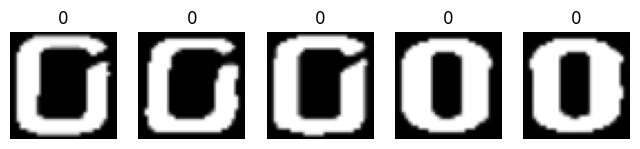

In [5]:
# Dataset Sanity Visualization

plt.figure(figsize=(8,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.title(idx_to_class[np.argmax(y[i])])
    plt.axis("off")
plt.show()


In [6]:
# Train / Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y.argmax(axis=1)
)


In [7]:
# CNN Model (UNCHANGED ARCHITECTURE)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


e:\NumberPlateRecognition\NPRecognition\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,203,701 (8.41 MB)

 Trainable params: 2,203,701 (8.41 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train Model

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64
)


Epoch 1/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6798 - loss: 1.2809 - val_accuracy: 0.9432 - val_loss: 0.2152
Epoch 2/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9133 - loss: 0.3129 - val_accuracy: 0.9701 - val_loss: 0.1296
Epoch 3/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9449 - loss: 0.1879 - val_accuracy: 0.9786 - val_loss: 0.0686
Epoch 4/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9604 - loss: 0.1333 - val_accuracy: 0.9837 - val_loss: 0.0597
Epoch 5/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9666 - loss: 0.1140 - val_accuracy: 0.9792 - val_loss: 0.0714
Epoch 6/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9702 - loss: 0.0989 - val_accuracy: 0.9824 - val_loss: 0.0619
Epoch 7/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9763 - loss: 0.0750 - val_accuracy: 0.9870 - val_loss: 0.0445
Epoch 8/15
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9800 - loss: 0.0675 - val_ac

In [9]:
# Save & Reload Model

os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, "char_cnn.h5"))

cnn = load_model(os.path.join(MODEL_DIR, "char_cnn.h5"))
print("✅ Model loaded successfully")


✅ Model loaded successfully


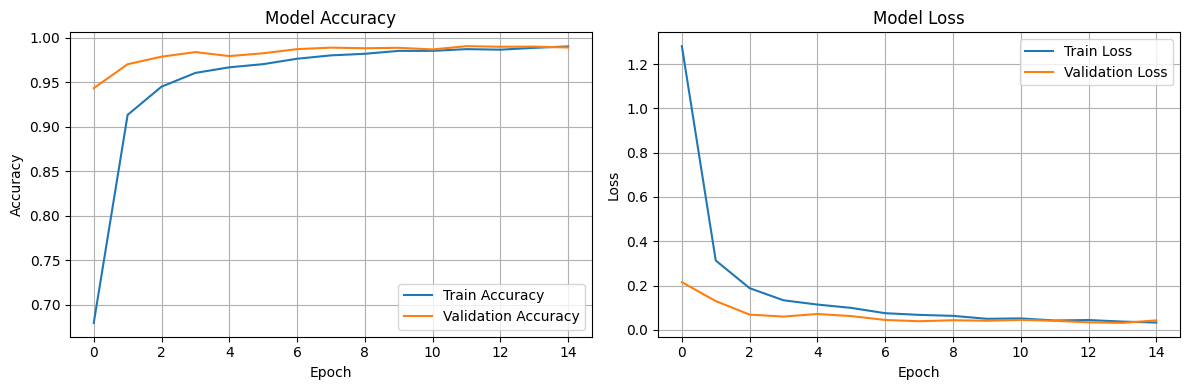

In [10]:
# TRAINING CURVES (ACCURACY & LOSS)

def plot_training_history(history):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Figure size 6000x6500 with 0 Axes>

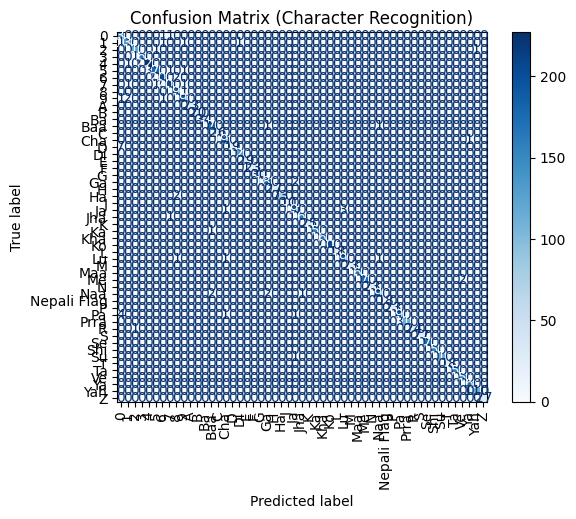

In [23]:
# CONFUSION MATRIX
 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[idx_to_class[i] for i in range(len(classes))]
)

plt.figure(figsize=(60,65))
disp.plot(
    cmap="Blues",
    xticks_rotation=90,
    values_format="d"
)
plt.title("Confusion Matrix (Character Recognition)")
plt.show()


In [12]:
# YOLO Label Utilities (UNCHANGED LOGIC)

def read_yolo_labels(label_file, img_w, img_h):
    boxes = []
    with open(label_file, "r") as f:
        for line in f:
            _, xc, yc, w, h = map(float, line.split())
            x = int((xc - w/2) * img_w)
            y = int((yc - h/2) * img_h)
            w = int(w * img_w)
            h = int(h * img_h)
            boxes.append((x, y, w, h))
    return boxes


In [13]:
# Character Extraction from Plate

def extract_characters(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    boxes = read_yolo_labels(label_path, w, h)
    chars = []

    for (x,y,wc,hc) in boxes:
        crop = img[y:y+hc, x:x+wc]
        if crop.size == 0:
            continue

        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        chars.append((x, gray))

    chars.sort(key=lambda c: c[0])
    return [c[1] for c in chars]


In [24]:
# Visualization + Recognition

def visualize_extracted_characters(img_path, label_path):
    chars = extract_characters(img_path, label_path)

    if not chars:
        print("❌ No characters extracted")
        return []

    plt.figure(figsize=(10,3))
    for i, ch in enumerate(chars):
        plt.subplot(1, len(chars), i+1)
        plt.imshow(ch, cmap="gray")
        plt.title(f"Char {i+1}")
        plt.axis("off")
    plt.show()

    return chars


In [15]:
def recognize_plate_from_path(img_path, label_path):
    chars = visualize_extracted_characters(img_path, label_path)

    plate_text = ""
    for ch in chars:
        ch = ch.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0
        pred = cnn.predict(ch, verbose=0)
        plate_text += idx_to_class[np.argmax(pred)]

    return plate_text


Image exists: True
Label exists: True


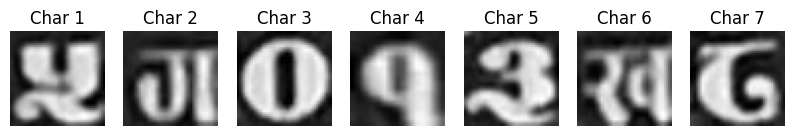

✅ Recognized Number Plate: 5Ga013Kha8


In [16]:
# FINAL TEST

TEST_IMAGE_PATH = r"E:\NumberPlateRecognition\Test\1\2021-03-23_12_53_45.jpg"
TEST_LABEL_PATH = r"E:\NumberPlateRecognition\Test\1\2021-03-23_12_53_45.txt"

print("Image exists:", os.path.exists(TEST_IMAGE_PATH))
print("Label exists:", os.path.exists(TEST_LABEL_PATH))

recognized = recognize_plate_from_path(TEST_IMAGE_PATH, TEST_LABEL_PATH)
print("✅ Recognized Number Plate:", recognized)


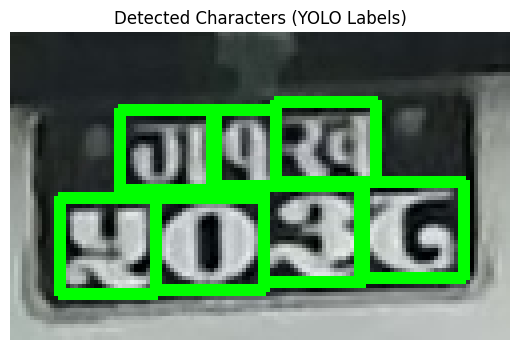

In [17]:
# Visualize bounding boxes on the plate (YOLO labels)

def visualize_plate_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    boxes = read_yolo_labels(label_path, w, h)

    for (x, y, bw, bh) in boxes:
        cv2.rectangle(img, (x, y), (x+bw, y+bh), (0,255,0), 2)

    plt.figure(figsize=(8,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Characters (YOLO Labels)")
    plt.axis("off")
    plt.show()


visualize_plate_with_boxes(TEST_IMAGE_PATH, TEST_LABEL_PATH)

In [18]:
# Show prediction per character

def recognize_with_confidence(chars):
    results = []
    for ch in chars:
        ch = ch.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0
        pred = cnn.predict(ch, verbose=0)[0]
        idx = np.argmax(pred)
        results.append((idx_to_class[idx], float(pred[idx])))
    return results


chars = extract_characters(TEST_IMAGE_PATH, TEST_LABEL_PATH)
results = recognize_with_confidence(chars)

for i, (char, conf) in enumerate(results):
    print(f"Char {i+1}: {char} ({conf:.2f})")


Char 1: 5 (1.00)
Char 2: Ga (1.00)
Char 3: 0 (1.00)
Char 4: 1 (0.99)
Char 5: 3 (1.00)
Char 6: Kha (1.00)
Char 7: 8 (1.00)


Image exists: True
Label exists: True


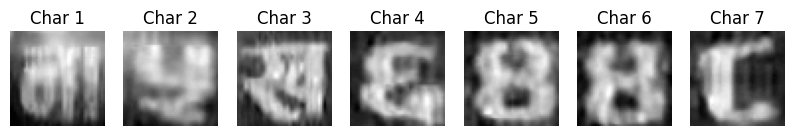

✅ Recognized Number Plate: Naa5Kha6448


In [25]:
# FINAL TEST

TEST_IMAGE_PATH = r"E:\NumberPlateRecognition\Test\1\2021-03-23_04_04_59.jpg"
TEST_LABEL_PATH = r"E:\NumberPlateRecognition\Test\1\2021-03-23_04_04_59.txt"

print("Image exists:", os.path.exists(TEST_IMAGE_PATH))
print("Label exists:", os.path.exists(TEST_LABEL_PATH))

recognized = recognize_plate_from_path(TEST_IMAGE_PATH, TEST_LABEL_PATH)
print("✅ Recognized Number Plate:", recognized)


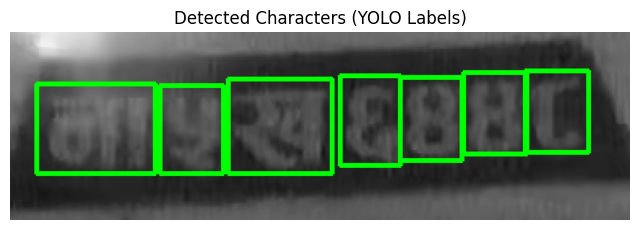

In [26]:
# Visualize bounding boxes on the plate (YOLO labels)

def visualize_plate_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    boxes = read_yolo_labels(label_path, w, h)

    for (x, y, bw, bh) in boxes:
        cv2.rectangle(img, (x, y), (x+bw, y+bh), (0,255,0), 2)

    plt.figure(figsize=(8,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Characters (YOLO Labels)")
    plt.axis("off")
    plt.show()


visualize_plate_with_boxes(TEST_IMAGE_PATH, TEST_LABEL_PATH)

In [27]:
# Show prediction per character

def recognize_with_confidence(chars):
    results = []
    for ch in chars:
        ch = ch.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0
        pred = cnn.predict(ch, verbose=0)[0]
        idx = np.argmax(pred)
        results.append((idx_to_class[idx], float(pred[idx])))
    return results


chars = extract_characters(TEST_IMAGE_PATH, TEST_LABEL_PATH)
results = recognize_with_confidence(chars)

for i, (char, conf) in enumerate(results):
    print(f"Char {i+1}: {char} ({conf:.2f})")


Char 1: Naa (1.00)
Char 2: 5 (1.00)
Char 3: Kha (1.00)
Char 4: 6 (1.00)
Char 5: 4 (1.00)
Char 6: 4 (1.00)
Char 7: 8 (1.00)
